In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-dataset/2022-10-leicestershire-street.csv
/kaggle/input/crime-dataset/2022-06-kent-street.csv
/kaggle/input/crime-dataset/2022-11-derbyshire-street.csv
/kaggle/input/crime-dataset/2022-07-kent-street.csv
/kaggle/input/crime-dataset/2022-02-leicestershire-street.csv
/kaggle/input/crime-dataset/2022-10-derbyshire-street.csv
/kaggle/input/crime-dataset/2022-03-kent-street.csv
/kaggle/input/crime-dataset/2022-07-leicestershire-street.csv
/kaggle/input/crime-dataset/2022-02-kent-street.csv
/kaggle/input/crime-dataset/2022-09-kent-street.csv
/kaggle/input/crime-dataset/2022-02-derbyshire-street.csv
/kaggle/input/crime-dataset/2022-01-derbyshire-street.csv
/kaggle/input/crime-dataset/2022-08-derbyshire-street.csv
/kaggle/input/crime-dataset/2022-11-leicestershire-street.csv
/kaggle/input/crime-dataset/2022-06-derbyshire-street.csv
/kaggle/input/crime-dataset/2022-11-kent-street.csv
/kaggle/input/crime-dataset/2022-06-leicestershire-street.csv
/kaggle/input/crime-dataset/20

# Install Pyspark

In [2]:
# Install pyspark version 3.2
!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 10.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805894 sha256=0dddd9632652213137016c16cdbef6c59e233b9c39fbd5ae2f501d891bc3f0bc
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
# Import spark session and intansiate it
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[4]").appName("datapreprocessing").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/27 12:54:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data Loading and Preprocessing

> **Load the Dataset**

In [4]:
# Load all the csv files from crime-dataset and show firsst 10 lines of the dataset
df = spark.read.csv("/kaggle/input/crime-dataset/*.csv", header= True, inferSchema=True)
df.show(10)

+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+
|            Crime ID|  Month|Reported by|Falls within|Longitude| Latitude|            Location|LSOA code|   LSOA name|          Crime type|Last outcome category|Context|
+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+
|b93c5583a3adce8a0...|2022-08|Kent Police| Kent Police| 0.973355|51.260972|On or near Lower ...|E01023987|Ashford 001B|            Burglary| Investigation com...|   null|
|330e17b2dc5af6854...|2022-08|Kent Police| Kent Police| 0.963316|51.258906|On or near New Fo...|E01023987|Ashford 001B|Criminal damage a...| Investigation com...|   null|
|794686e451d00c2c8...|2022-08|Kent Police| Kent Police| 0.958126|51.259568|On or near New Fo...|E01023987|Ashford 001B|         Other theft| Inve

In [5]:
# Renaming the columns in the dataframe and print the name for changed columns
df = df.toDF("Crime_ID", "Month", "Reported_By", "Falls_Within", "Longitude", "Latitude", "Location", "LSOA_Code", "LSOA_Name", "Crime_Type", "Last_Outcome_Category", "Context")
#print(df.columns)
df.show()

+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+
|            Crime_ID|  Month|Reported_By|Falls_Within|Longitude| Latitude|            Location|LSOA_Code|   LSOA_Name|          Crime_Type|Last_Outcome_Category|Context|
+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+
|b93c5583a3adce8a0...|2022-08|Kent Police| Kent Police| 0.973355|51.260972|On or near Lower ...|E01023987|Ashford 001B|            Burglary| Investigation com...|   null|
|330e17b2dc5af6854...|2022-08|Kent Police| Kent Police| 0.963316|51.258906|On or near New Fo...|E01023987|Ashford 001B|Criminal damage a...| Investigation com...|   null|
|794686e451d00c2c8...|2022-08|Kent Police| Kent Police| 0.958126|51.259568|On or near New Fo...|E01023987|Ashford 001B|         Other theft| Inve

> **Extract and Standardise County Names**

In [6]:
# Extracting and Standardise county names by mapping each police force to county name
from pyspark.sql.functions import when,col
df = df.withColumn("County", when(col("Reported_By") == "Derbyshire Constabulary", "Derbyshire")
    .when(col("Reported_By") == "Leicestershire Police", "Leicestershire")
    .when(col("Reported_By") == "Kent Police", "Kent") 
# Any other police force gets None or you can replace with 'Unknown'
    .otherwise(None)
)
df.show()

+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+------+
|            Crime_ID|  Month|Reported_By|Falls_Within|Longitude| Latitude|            Location|LSOA_Code|   LSOA_Name|          Crime_Type|Last_Outcome_Category|Context|County|
+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+------+
|b93c5583a3adce8a0...|2022-08|Kent Police| Kent Police| 0.973355|51.260972|On or near Lower ...|E01023987|Ashford 001B|            Burglary| Investigation com...|   null|  Kent|
|330e17b2dc5af6854...|2022-08|Kent Police| Kent Police| 0.963316|51.258906|On or near New Fo...|E01023987|Ashford 001B|Criminal damage a...| Investigation com...|   null|  Kent|
|794686e451d00c2c8...|2022-08|Kent Police| Kent Police| 0.958126|51.259568|On or near New Fo...|E01023987|Ashf

#  Descriptive Data Analysis using Spark SQL

> **Total Crimes by County**

In [7]:
# Creating a temporary SQL view
df.createOrReplaceTempView("CrimeDatabase")
# Calculating total crimes per county
df_total_number_of_crimes_sql = spark.sql("""
    SELECT County, COUNT(*) AS total_crimes
    FROM CrimeDatabase
    GROUP BY County
""")
df_total_number_of_crimes_sql.show()

+--------------+------------+
|        County|total_crimes|
+--------------+------------+
|          Kent|      200945|
|Leicestershire|      115179|
|    Derbyshire|      110805|
+--------------+------------+



> **Monthly Crime Trends for Kent, Leicestershire, and  Derbyshire**

In [8]:
# Calculate crimes per month for Kent county
Kent_crimes_per_month = spark.sql(""" SELECT Month,COUNT(Month) as Crimes_per_Month_Kent
                                FROM CrimeDatabase
                                WHERE County = "Kent"
                                GROUP BY Month
                                ORDER BY to_date (Month,"yyyy-MM")
                                """)
Kent_crimes_per_month.show()

+-------+---------------------+
|  Month|Crimes_per_Month_Kent|
+-------+---------------------+
|2022-01|                16338|
|2022-02|                15383|
|2022-03|                17310|
|2022-04|                17144|
|2022-05|                17546|
|2022-06|                17388|
|2022-07|                17950|
|2022-08|                18365|
|2022-09|                16574|
|2022-10|                16172|
|2022-11|                15799|
|2022-12|                14976|
+-------+---------------------+



In [9]:
# Month in which maximum number of crimes took place in Kent county in year 2022
from pyspark.sql.functions import max,min
Kent_max_crimes =  Kent_crimes_per_month \
    .orderBy("Crimes_per_Month_Kent", ascending=False) \
    .select("Month", "Crimes_per_Month_Kent") \
    .limit(1)
Kent_max_crimes.show()

+-------+---------------------+
|  Month|Crimes_per_Month_Kent|
+-------+---------------------+
|2022-08|                18365|
+-------+---------------------+



In [10]:
# Month in which minimum number of crimes took place in Kent county in year 2022
Kent_min_crimes = Kent_crimes_per_month \
    .orderBy("Crimes_per_Month_Kent", ascending=True) \
    .select("Month", "Crimes_per_Month_Kent") \
    .limit(1)
Kent_min_crimes.show()

+-------+---------------------+
|  Month|Crimes_per_Month_Kent|
+-------+---------------------+
|2022-12|                14976|
+-------+---------------------+



In [11]:
# Calculate crimes per month for Leicestershire county
Leicestershire_crimes_per_month = spark.sql(""" SELECT Month,COUNT(Month) as Crimes_per_Month_Leicestershire
                                FROM CrimeDatabase
                                WHERE County = "Leicestershire"
                                GROUP BY Month
                                ORDER BY to_date (Month,"yyyy-MM")
                                """)
Leicestershire_crimes_per_month.show()

+-------+-------------------------------+
|  Month|Crimes_per_Month_Leicestershire|
+-------+-------------------------------+
|2022-01|                           8730|
|2022-02|                           8482|
|2022-03|                          10019|
|2022-04|                           9494|
|2022-05|                          10332|
|2022-06|                           9980|
|2022-07|                          10056|
|2022-08|                          10373|
|2022-09|                           9492|
|2022-10|                           9802|
|2022-11|                           9816|
|2022-12|                           8603|
+-------+-------------------------------+



In [12]:
# Month in which maximum number of crimes took place in Leicestershire county in year 2022
Leicestershire_max_crimes = Leicestershire_crimes_per_month \
    .orderBy("Crimes_per_Month_Leicestershire", ascending=False) \
    .select("Month", "Crimes_per_Month_Leicestershire") \
    .limit(1)
Leicestershire_max_crimes.show()

+-------+-------------------------------+
|  Month|Crimes_per_Month_Leicestershire|
+-------+-------------------------------+
|2022-08|                          10373|
+-------+-------------------------------+



In [13]:
# Month in which minimum number of crimes took place in Leicestershire county in year 2022
Leicestershire_min_crimes = Leicestershire_crimes_per_month \
    .orderBy("Crimes_per_Month_Leicestershire", ascending=True) \
    .select("Month", "Crimes_per_Month_Leicestershire") \
    .limit(1)
Leicestershire_min_crimes.show()

+-------+-------------------------------+
|  Month|Crimes_per_Month_Leicestershire|
+-------+-------------------------------+
|2022-02|                           8482|
+-------+-------------------------------+



In [14]:
# Calculate crimes per month for Derbyshire county
Derbyshire_crimes_per_month = spark.sql(""" SELECT Month,COUNT(Month) as Crimes_per_Month_Derbyshire
                                FROM CrimeDatabase
                                WHERE County = "Derbyshire"
                                GROUP BY Month
                                ORDER BY to_date (Month,"yyyy-MM")
                                """)
Derbyshire_crimes_per_month.show()


+-------+---------------------------+
|  Month|Crimes_per_Month_Derbyshire|
+-------+---------------------------+
|2022-01|                       8991|
|2022-02|                       8452|
|2022-03|                       9598|
|2022-04|                       9409|
|2022-05|                      10140|
|2022-06|                       9710|
|2022-07|                      10017|
|2022-08|                       9571|
|2022-09|                       8781|
|2022-10|                       9205|
|2022-11|                       8923|
|2022-12|                       8008|
+-------+---------------------------+



In [15]:
# Month in which maximum number of crimes took place in Derbyshire county in year 2022
Derbyshire_max_crimes = Derbyshire_crimes_per_month \
    .orderBy("Crimes_per_Month_Derbyshire", ascending=False) \
    .select("Month", "Crimes_per_Month_Derbyshire") \
    .limit(1)
Derbyshire_max_crimes.show()

+-------+---------------------------+
|  Month|Crimes_per_Month_Derbyshire|
+-------+---------------------------+
|2022-05|                      10140|
+-------+---------------------------+



In [16]:
# Month in which minimum number of crimes took place in Derbyshire county in year 2022
Derbyshire_min_crimes = Derbyshire_crimes_per_month \
    .orderBy("Crimes_per_Month_Derbyshire", ascending=True) \
    .select("Month", "Crimes_per_Month_Derbyshire") \
    .limit(1)
Derbyshire_min_crimes.show()

+-------+---------------------------+
|  Month|Crimes_per_Month_Derbyshire|
+-------+---------------------------+
|2022-12|                       8008|
+-------+---------------------------+



> **Crime Type Analysis for Kent, Leicestershire, and  Derbyshire**

In [17]:
# Ranking crime types in ascending order according to their frequency in Kent county in year 2022 
Kent_crime_type = spark.sql(""" SELECT Crime_Type, COUNT(Crime_Type) as Crimes_type_Kent
                                FROM CrimeDatabase
                                WHERE County = "Kent"
                                GROUP BY Crime_Type
                                ORDER BY Crime_Type
                                """)
Kent_crime_type.orderBy("Crimes_type_Kent").show()

+--------------------+----------------+
|          Crime_Type|Crimes_type_Kent|
+--------------------+----------------+
|Theft from the pe...|            1007|
|       Bicycle theft|            1086|
|             Robbery|            1332|
|Possession of wea...|            1336|
|               Drugs|            4409|
|         Other crime|            5601|
|            Burglary|            6846|
|       Vehicle crime|            9556|
|         Shoplifting|           11941|
|        Public order|           12332|
|         Other theft|           14318|
|Criminal damage a...|           19936|
|Anti-social behav...|           27904|
|Violence and sexu...|           83341|
+--------------------+----------------+



In [18]:
# Most common crime type in Kent county in year 2022
Kent_most_common_crime_type = Kent_crime_type \
    .orderBy("Crimes_type_Kent", ascending=False) \
    .select("Crime_Type", "Crimes_type_Kent") \
    .limit(1)
Kent_most_common_crime_type.show()

+--------------------+----------------+
|          Crime_Type|Crimes_type_Kent|
+--------------------+----------------+
|Violence and sexu...|           83341|
+--------------------+----------------+



In [19]:
#### Least common crime type in Kent county in year 2022
Kent_least_common_crime_type = Kent_crime_type \
    .orderBy("Crimes_type_Kent", ascending=True) \
    .select("Crime_Type", "Crimes_type_Kent") \
    .limit(1)
Kent_least_common_crime_type.show()

+--------------------+----------------+
|          Crime_Type|Crimes_type_Kent|
+--------------------+----------------+
|Theft from the pe...|            1007|
+--------------------+----------------+



In [20]:
# Ranking crime types in ascending order according to their frequency in Leicestershire county in year 2022 
Leicestershire_crime_type = spark.sql(""" SELECT Crime_Type, COUNT(Crime_Type) as Crimes_type_Leicestershire
                                FROM CrimeDatabase
                                WHERE County = "Leicestershire"
                                GROUP BY Crime_Type
                                ORDER BY Crime_Type
                                """)
Leicestershire_crime_type.orderBy("Crimes_type_Leicestershire").show()

+--------------------+--------------------------+
|          Crime_Type|Crimes_type_Leicestershire|
+--------------------+--------------------------+
|             Robbery|                       811|
|Theft from the pe...|                       891|
|Possession of wea...|                      1037|
|       Bicycle theft|                      1947|
|         Other crime|                      2590|
|               Drugs|                      3416|
|         Shoplifting|                      4283|
|            Burglary|                      5469|
|       Vehicle crime|                      7059|
|         Other theft|                      9327|
|Anti-social behav...|                      9601|
|Criminal damage a...|                     10963|
|        Public order|                     13766|
|Violence and sexu...|                     44019|
+--------------------+--------------------------+



In [21]:
# Most common crime type in Leicestershire county in year 2022
Leicestershire_most_common_crime_type = Leicestershire_crime_type \
    .orderBy("Crimes_type_Leicestershire", ascending=False) \
    .select("Crime_Type", "Crimes_type_Leicestershire") \
    .limit(1)
Leicestershire_most_common_crime_type.show()

+--------------------+--------------------------+
|          Crime_Type|Crimes_type_Leicestershire|
+--------------------+--------------------------+
|Violence and sexu...|                     44019|
+--------------------+--------------------------+



In [22]:
# Least common crime type in Leicestershire county in year 2022
Leicestershire_least_common_crime_type = Leicestershire_crime_type \
    .orderBy("Crimes_type_Leicestershire", ascending=True) \
    .select("Crime_Type", "Crimes_type_Leicestershire") \
    .limit(1)
Leicestershire_least_common_crime_type.show()

+----------+--------------------------+
|Crime_Type|Crimes_type_Leicestershire|
+----------+--------------------------+
|   Robbery|                       811|
+----------+--------------------------+



In [23]:
# Ranking crime types in ascending order according to their frequency in Derbyshire county in year 2022 
Derbyshire_crime_type = spark.sql(""" SELECT Crime_Type, COUNT(Crime_Type) as Crimes_type_Derbyshire
                                FROM CrimeDatabase
                                WHERE County = "Derbyshire"
                                GROUP BY Crime_Type
                                ORDER BY Crime_Type  
                                """)
Derbyshire_crime_type.orderBy("Crimes_type_Derbyshire").show()

+--------------------+----------------------+
|          Crime_Type|Crimes_type_Derbyshire|
+--------------------+----------------------+
|       Bicycle theft|                   604|
|Theft from the pe...|                   767|
|             Robbery|                   769|
|Possession of wea...|                   949|
|         Other crime|                  2053|
|               Drugs|                  2292|
|            Burglary|                  3806|
|         Shoplifting|                  4237|
|       Vehicle crime|                  4669|
|         Other theft|                  6821|
|Criminal damage a...|                  8724|
|        Public order|                 10198|
|Anti-social behav...|                 23038|
|Violence and sexu...|                 41878|
+--------------------+----------------------+



In [24]:
# Most common crime type in Derbyshire county in year 2022
Derbyshire_most_common_crime_type = Derbyshire_crime_type \
    .orderBy("Crimes_type_Derbyshire", ascending=False) \
    .select("Crime_Type", "Crimes_type_Derbyshire") \
    .limit(1)
Derbyshire_most_common_crime_type.show()

+--------------------+----------------------+
|          Crime_Type|Crimes_type_Derbyshire|
+--------------------+----------------------+
|Violence and sexu...|                 41878|
+--------------------+----------------------+



In [25]:
# Least common crime type in Derbyshire county in year 2022
Derbyshire_least_common_crime_type = Derbyshire_crime_type \
    .orderBy("Crimes_type_Derbyshire", ascending=True) \
    .select("Crime_Type", "Crimes_type_Derbyshire") \
    .limit(1)
Derbyshire_least_common_crime_type.show()

+-------------+----------------------+
|   Crime_Type|Crimes_type_Derbyshire|
+-------------+----------------------+
|Bicycle theft|                   604|
+-------------+----------------------+



In [26]:
# Converting spark data frame to pandas data frame
df_pandas_kent_crimes_per_month = Kent_crimes_per_month.toPandas()
df_pandas_leicestershire_crimes_per_month = Leicestershire_crimes_per_month.toPandas()
df_pandas_derbyshire_crimes_per_month = Derbyshire_crimes_per_month.toPandas()

In [27]:
# Merging all the three pandas dataframe into one
from functools import reduce
number_of_crime_pandas_dfs = [df_pandas_kent_crimes_per_month,df_pandas_leicestershire_crimes_per_month,df_pandas_derbyshire_crimes_per_month]
number_of_crime_final_df = reduce(lambda left,right: pd.merge(left,right,on=["Month"],how='outer'),number_of_crime_pandas_dfs)
    

> **Crime Type Breakdown by County**

Text(0.5, 1.0, 'Monthly Crimes')

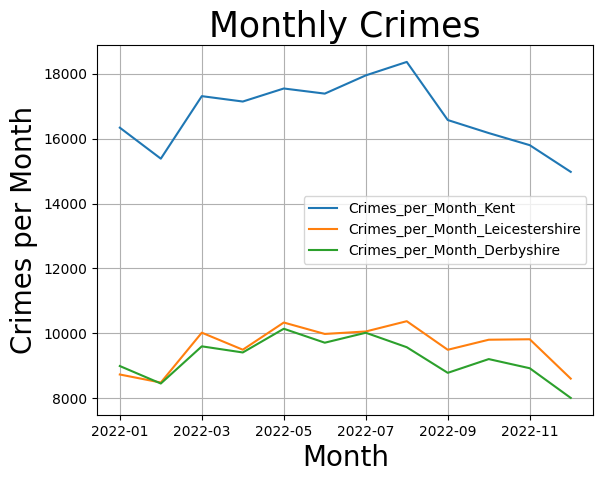

In [28]:
# Plotting line plot graph for monthly crimes
import matplotlib.pyplot as plt
number_of_crime_final_df.plot(kind="line", x = "Month" )
plt.xlabel("Month",  size = 20)
plt.ylabel("Crimes per Month", size = 20)
plt.grid()
plt.title("Monthly Crimes", size = 25)

In [29]:
# Converting all the three spark data frames to pandas dataframe
df_pandas_crime_type_kent = Kent_crime_type.toPandas()
df_pandas_crime_type_leicestershire = Leicestershire_crime_type.toPandas()
df_pandas_crime_type_derbyshire = Derbyshire_crime_type.toPandas()

In [30]:
# Merging all the three pandas dataframe into one 
Crime_type_pandas_df = [df_pandas_crime_type_derbyshire, df_pandas_crime_type_leicestershire, df_pandas_crime_type_kent]
Crime_type_final_df = reduce (lambda left,right: pd.merge(left,right,on=["Crime_Type"], how = "outer"),Crime_type_pandas_df)

Text(0.5, 1.0, 'Crime_Type')

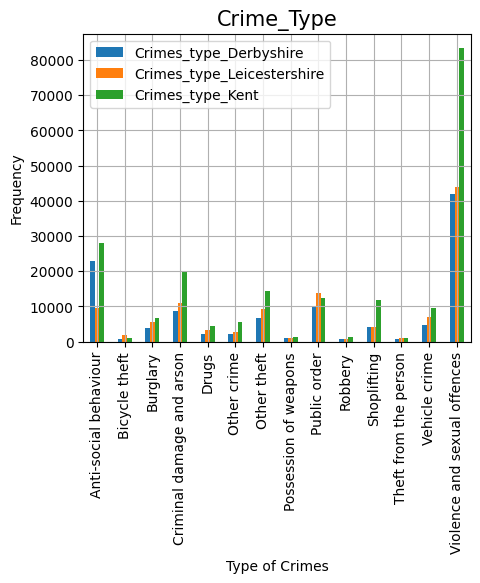

In [31]:
# Plotting bar graph for comparing crime types across counties
Crime_type_final_df.plot(kind = "bar" , x = "Crime_Type" , figsize = (5,4))
plt.xlabel("Type of Crimes", size=10)
plt.ylabel("Frequency", size=10)
plt.grid()
plt.title("Crime_Type", size=15)

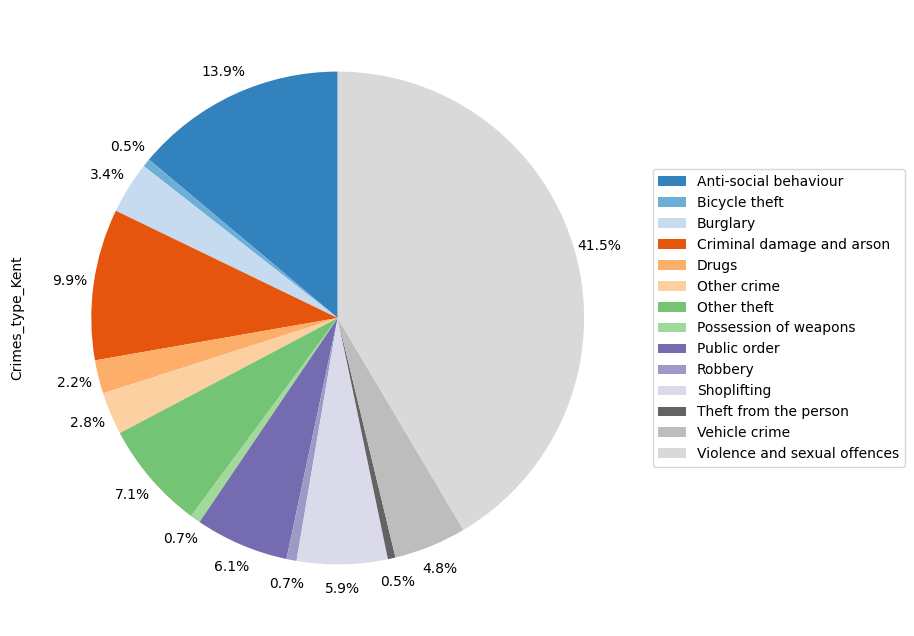

In [32]:
# Plotting pie chart to show distribution of crime types in Kent county in year 2022
kent_colors = plt.get_cmap('tab20c',len(df_pandas_crime_type_kent))(range(len(df_pandas_crime_type_kent)))
df_pandas_crime_type_kent.plot(kind = "pie",
                               y = "Crimes_type_Kent", 
                               labels = None,
                               figsize=(8,8),
                               autopct = "%.1f%%",
                               startangle = 90,
                               colors = kent_colors,
                               pctdistance=1.1)
                                
plt.legend(df_pandas_crime_type_kent['Crime_Type'],loc="center left",bbox_to_anchor=(1, 0.5))
plt.show()

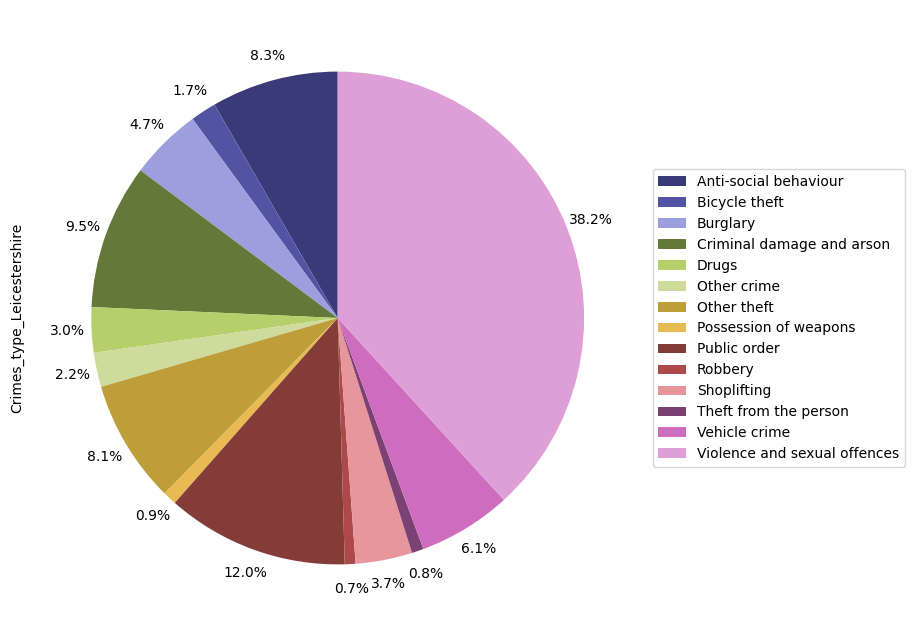

In [33]:
# Plotting pie chart to show distribution of crime types in Leicestershire county in year 2022
leicestershire_colors = plt.get_cmap('tab20b',len(df_pandas_crime_type_leicestershire))(range(len(df_pandas_crime_type_leicestershire)))
df_pandas_crime_type_leicestershire.plot(kind = "pie",
                               y = "Crimes_type_Leicestershire", 
                               labels = None,
                               figsize=(8,8),
                               autopct = "%.1f%%",
                               startangle = 90,
                               colors = leicestershire_colors,
                               pctdistance=1.1)
                                
plt.legend(df_pandas_crime_type_leicestershire['Crime_Type'],loc="center left",bbox_to_anchor=(1, 0.5))
plt.show()

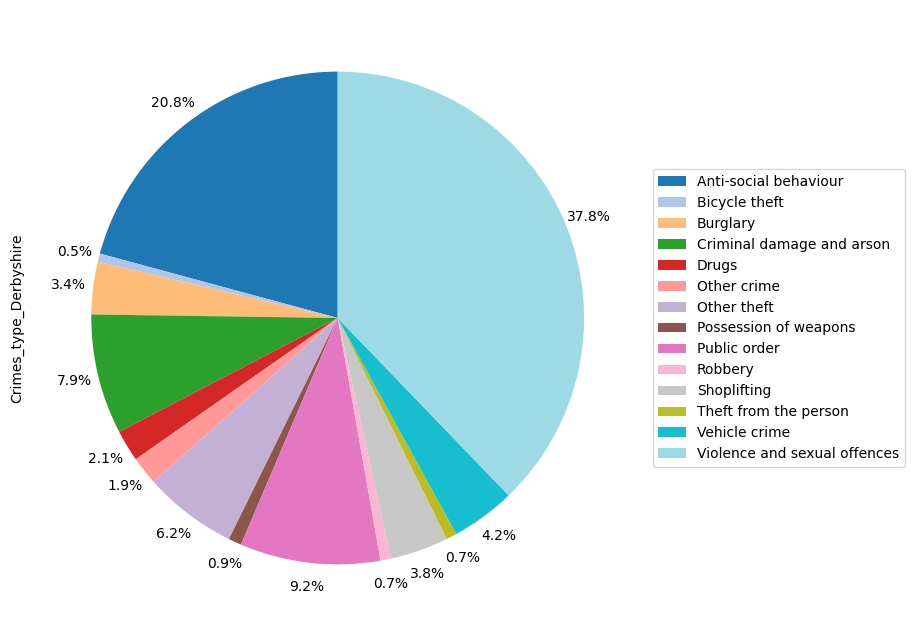

In [34]:
# Plotting pie chart to show distribution of crime types in Derbyshire county in year 2022
derbyshire_colors = plt.get_cmap('tab20',len(df_pandas_crime_type_derbyshire))(range(len(df_pandas_crime_type_derbyshire)))
df_pandas_crime_type_derbyshire.plot(kind = "pie",
                               y = "Crimes_type_Derbyshire", 
                               labels = None,
                               figsize=(8,8),
                               autopct = "%.1f%%",
                               startangle = 90,
                               colors = derbyshire_colors,
                               pctdistance=1.1)
                                
plt.legend(df_pandas_crime_type_derbyshire['Crime_Type'],loc="center left",bbox_to_anchor=(1, 0.5))
plt.show()